<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta
import os
import re
from functools import reduce
from collections import defaultdict
from scipy import stats 
from scipy.stats import norm

# Customer Analysis

In [2]:
np.sort(os.listdir())

array(['.config', '1_customers_dataset.csv',
       '1_order_payments_dataset.csv', '1_orders_dataset.csv',
       'KPMG_VI_New_raw_data_update_final.csv',
       'KPMG_VI_New_raw_data_update_final.xlsx',
       'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
       'WA_Fn-UseC_-Telco-Customer-Churn.csv', 'ab_experiment.csv',
       'app_wau.csv', 'bz_data_analyis.csv', 'cookie_cats.csv',
       'ecommerce-data.csv', 'groceries.csv', 'lead_conversion.csv',
       'mall_customers.csv', 'match_result_test.csv',
       'mock_sales_data.csv', 'online_retail.xlsx',
       'online_retail_II.xlsx', 'sales.csv', 'sales_data_with_stores.csv',
       'sales_vs_discount.csv', 'sample-sales-data.csv', 'sample_data',
       'scanner_data.csv', 'test.csv'], dtype='<U49')

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index().rename(columns = {'userid':'cnt'})
cnt = cnt[cnt['result'] == True]
cnt

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


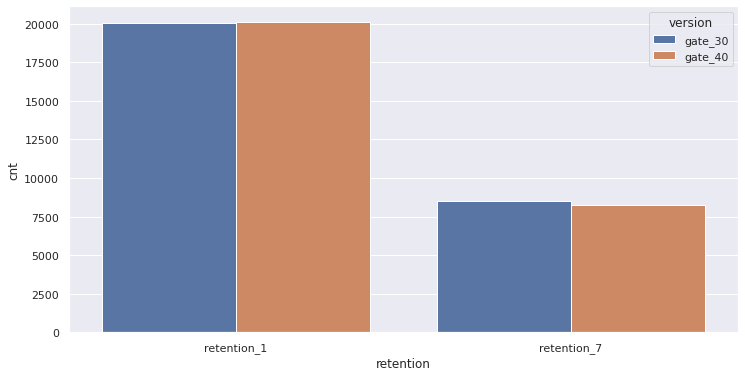

In [8]:
sns.set(rc = {'figure.figsize' : [12,6]})
sns.barplot(data = cnt, x = 'retention', y = 'cnt', hue = 'version')
plt.show()

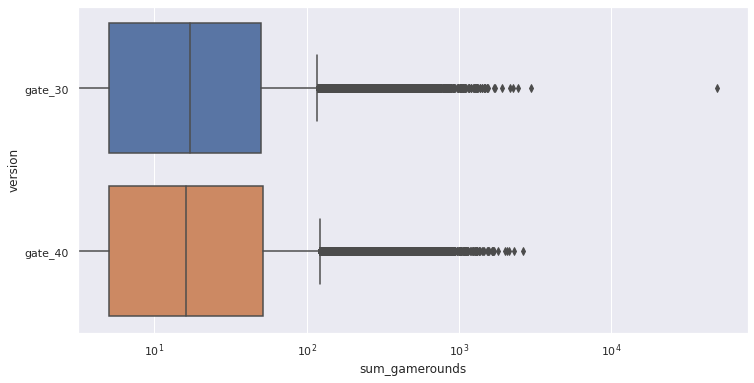

In [9]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

In [10]:
df = df[df['sum_gamerounds'] <= 10000]

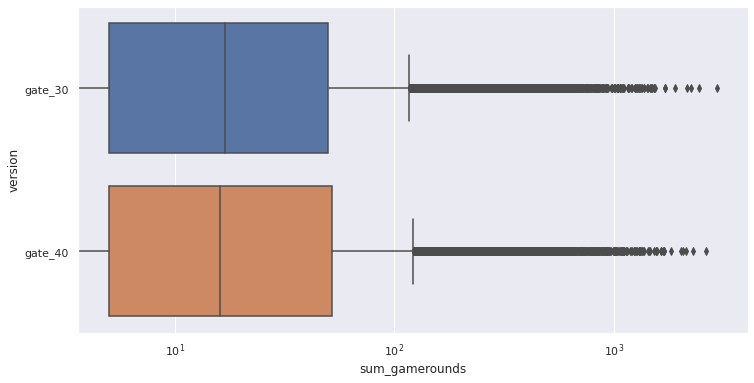

In [11]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

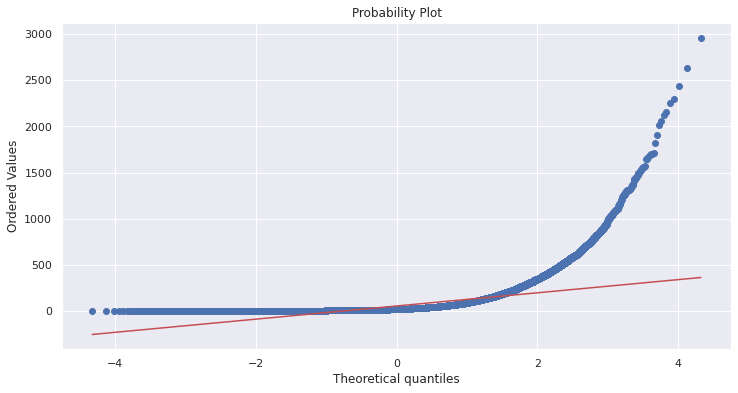

In [12]:
stats.probplot(df['sum_gamerounds'], dist ='norm', plot = plt)
plt.show()

In [13]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(str(stat), '\t', str(p))

18528909.99029161 	 0.0


In [21]:
res = stats.anderson(df['sum_gamerounds'])
res

AndersonResult(statistic=13369.548966017013, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [23]:
res2 = zip(res.critical_values, res.significance_level)

In [24]:
[f'Probably Gaussian : critical value is {crit}, sigificant level is {sig}' 
 if crit > sig
 else f'Probably not Gaussian : critical value is {crit}, sigificant level is {sig}' 
 for crit, sig in res2
 ]

['Probably not Gaussian : critical value is 0.576, sigificant level is 15.0',
 'Probably not Gaussian : critical value is 0.656, sigificant level is 10.0',
 'Probably not Gaussian : critical value is 0.787, sigificant level is 5.0',
 'Probably not Gaussian : critical value is 0.918, sigificant level is 2.5',
 'Probably Gaussian : critical value is 1.092, sigificant level is 1.0']

In [15]:
n = 1000
boots = pd.DataFrame(
    [df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots.head()

version,gate_30,gate_40
sum_gamerounds,49.195913,52.386097
sum_gamerounds,51.173467,49.026246
sum_gamerounds,52.991637,50.847443
sum_gamerounds,52.140382,53.481417
sum_gamerounds,51.272345,48.869971


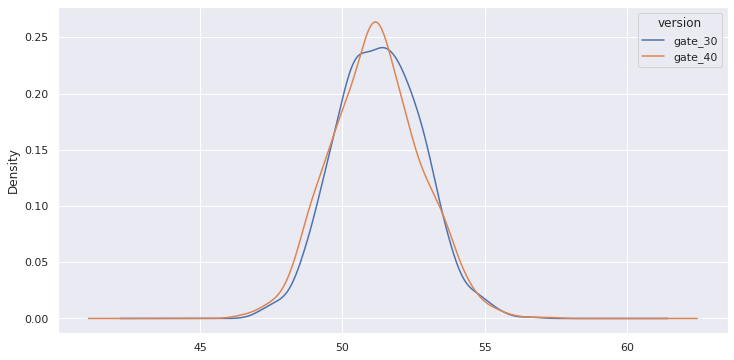

In [16]:
boots.plot.kde()

In [17]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff > 0])/n

0.522

In [19]:
z_mean = np.mean(boots['gate_30']) - np.mean(boots['gate_40'])
z_sigma = np.sqrt(
    np.var(boots['gate_30'])/n + np.var(boots['gate_40'])/n
)
alpha = .05
ci_diff= [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma]

In [20]:
print(f'z mean : {z_mean}')
print(f'z sigma : {z_sigma}')
print(f'ci diff : {ci_diff[0]} {ci_diff[1]}')

z mean : 0.12217923285564325
z sigma : 0.06876605094391786
ci diff : -0.012599750353482347 0.2569582160647689


In [40]:
res = stats.anderson(diff)
res2 = zip(res.critical_values, res.significance_level)

In [41]:
[f'probably gaussian : critical value = {crit}, significant level = {sig}'
if crit > sig
 else f'probably not gaussian : critical value = {crit}, significant level = {sig}'
 for crit, sig in res2
]

['probably not gaussian : critical value = 0.574, significant level = 15.0',
 'probably not gaussian : critical value = 0.653, significant level = 10.0',
 'probably not gaussian : critical value = 0.784, significant level = 5.0',
 'probably not gaussian : critical value = 0.914, significant level = 2.5',
 'probably gaussian : critical value = 1.088, significant level = 1.0']

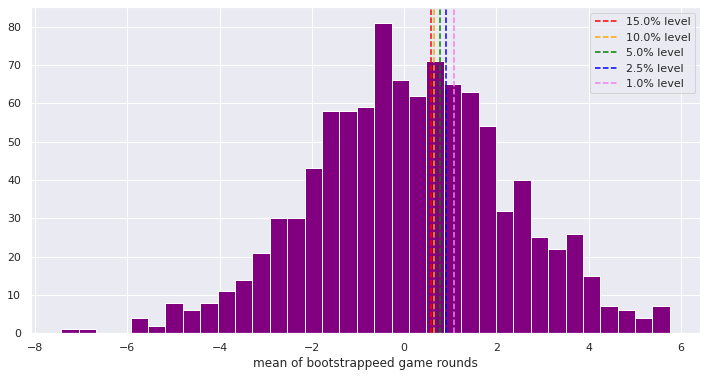

In [50]:
cols = ['red', 'orange', 'green','blue','violet']
plt.hist(diff, color = 'purple', bins = 35)

for i, (crit, sig) in enumerate(zip(res.critical_values, res.significance_level)) :
  plt.axvline(crit, color = cols[i], linestyle = '--',label = f'{sig}% level')


plt.legend()
plt.xlabel('mean of bootstrappeed game rounds')

plt.show()

# Iterators

In [51]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [52]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}